# Playing with a model

In this notebook, we will use a Conditional Diffusion model to generate designs. These can be quite large and might not fit in your GPU memory. You can skip the training part and download a model from wandb.

## Preliminaries

First let's make sure we have the necessary packages installed. Be sure to create a virtual environment, then install the required packages for this project in it.

In [1]:
# Some imports we will need
import os

if "google.colab" in str(get_ipython()):
    if not os.path.exists("EngiOpt"):
        !git clone https://github.com/IDEALLab/EngiOpt.git
    %cd EngiOpt

%pip install -e .

from diffusers import UNet2DConditionModel
import matplotlib.pyplot as plt
import numpy as np
import torch as th

from engiopt import metrics
from engiopt.diffusion_2d_cond.diffusion_2d_cond import beta_schedule
from engiopt.diffusion_2d_cond.diffusion_2d_cond import DiffusionSampler
import wandb

Obtaining file:///Users/ffelte/Documents/EngiLearn
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/mdolab/pyoptsparse to /private/var/folders/fw/69hmbxm946l1xycg8w29nw0800l9gd/T/pip-install-2zqkk3a_/pyoptsparse_1b3c0b5ff79445bcbebb5597d2cdf47a
  Running command git clone --filter=blob:none --quiet https://github.com/mdolab/pyoptsparse /private/var/folders/fw/69hmbxm946l1xycg8w29nw0800l9gd/T/pip-install-2zqkk3a_/pyoptsparse_1b3c0b5ff79445bcbebb5597d2cdf47a
  Resolved https://github.com/mdolab/pyoptsparse to commit 9d417c740693dc706fef8ff2c064837fea04ec50
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Building editable for engiopt (pyproject.toml) ... done
  Created wheel for engiopt: filename=engiopt-0.0.1-0.edit

/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Be sure to set the WANDB_API_KEY environment variable, you can go to [wandb](https://wandb.ai/site) to get your API key.


In [ ]:
# Be sure to set the WANDB_API_KEY environment variable
!export WANDB_API_KEY=00000000000000000000000000000000
!wandb login

Let's make sure we can interact with the problem in EngiBench.

(<Figure size 800x400 with 2 Axes>, <Axes: >)

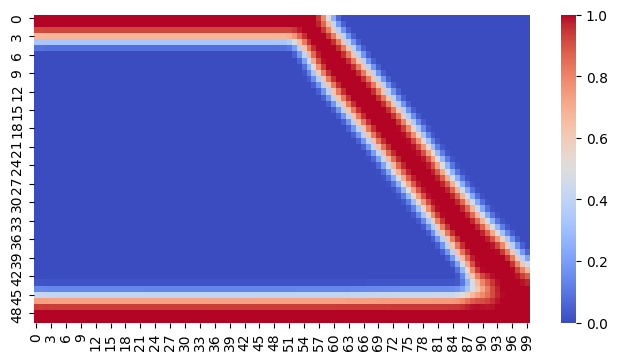

In [3]:
from engibench.problems.beams2d.v0 import Beams2D

problem = Beams2D()
problem.reset(seed=1)
design, _ = problem.random_design()
problem.render(design)

## Training a model

In EngiOpt, we have a collection of models that can be used to generate designs.

Each model is defined under a dedicated folder in the `engiopt` package.

For example, the `diffusion_2d_cond` folder contains the code for the Conditional Diffusion model.

In each model folder, there are two scripts; one for training the model, and one for evaluating the model.

To train a model, we can use the `diffusion_2d_cond.py` script. There is a command line interface that can be used to specify the model parameters.

To see the available options, we can use the `-h` flag.


In [4]:
!python engiopt/diffusion_2d_cond/diffusion_2d_cond.py -h

/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ffelte/Documents/EngiLearn/.venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
usage: diffusion_2d_cond.py [-h] [OPTIONS]

Command-line arguments.

╭─ options ──────────────────────────────────────────────────────────────────╮
│ -h, --help              show this help message and exit                    │
│ --problem-id STR        Problem identifier. (default: beams2d)             │
│ --algo STR              The name of this algorithm. (default:              │
│                         diffusion_2d_cond)                                 │
│ --track, --no-track     Track the experiment with wandb. (default: True)   │
│ --wandb-project STR     Wan

Now, let's say we want to train the model for the heat conduction problem, use weights and biases to track the training process, and save the resulting model in wandb. The resulting command would look like this (will take a while to run):

In [ ]:
!python engiopt/diffusion_2d_cond/diffusion_2d_cond.py --problem-id "beams2d" --track --wandb-entity None --save-model --n-epochs 200 --seed 1

## Restoring a model

After training a model, we can: 
1. Download a model from wandb
2. Instantiade the model and its sampler from the artifact

In [5]:
## Downloading a model from wandb
problem_id = "beams2d"
seed = 1

# This is the name of the model in wandb, for the sake of the example we will use a model that is stored on the official engiopt wandb project. If you want to use a model that you trained yourself, you can change the artifact_path to the path of your model.
artifact_path = f"engibench/engiopt/{problem_id}_diffusion_2d_cond_model:seed_{seed}"

api = wandb.Api()
artifact = api.artifact(artifact_path, type="model")
artifact_dir = artifact.download()
ckpt_path = os.path.join(artifact_dir, "model.pth")

if th.cuda.is_available():
    device = th.device("cuda")
elif th.backends.mps.is_available():
    device = th.device("mps")
else:
    device = th.device("cpu")

ckpt = th.load(ckpt_path, map_location=device)

# We will also need the "run" object to get the model configuration which was used to train the model.
run = artifact.logged_by()

# This is the model definition that was used to train the model. You can find the definition in the engiopt/diffusion_2d_cond/diffusion_2d_cond.py file.
model = UNet2DConditionModel(
    sample_size=problem.design_space.shape,
    in_channels=1,
    out_channels=1,
    cross_attention_dim=64,
    block_out_channels=(32, 64, 128, 256),
    down_block_types=("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
    layers_per_block=run.config["layers_per_block"],
    transformer_layers_per_block=1,
    encoder_hid_dim=len(problem.conditions),
    only_cross_attention=True,
).to(device)

model.load_state_dict(ckpt["model"])
model.eval()

# The noise schedule must also be restored
options = {
    "cosine": run.config["noise_schedule"] == "cosine",
    "exp_biasing": run.config["noise_schedule"] == "exp",
    "exp_bias_factor": 1,
}
betas = beta_schedule(
    t=run.config["num_timesteps"],
    start=1e-4,
    end=0.02,
    scale=1.0,
    options=options,
)
ddm_sampler = DiffusionSampler(run.config["num_timesteps"], betas)

wandb: Downloading large artifact beams2d_diffusion_2d_cond_model:seed_1, 200.90MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2
/var/folders/fw/69hmbxm946l1xycg8w29nw0800l9gd/T/ipykernel_29218/24936391.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the

## Sampling from a model

Now we can use the model to generate designs.

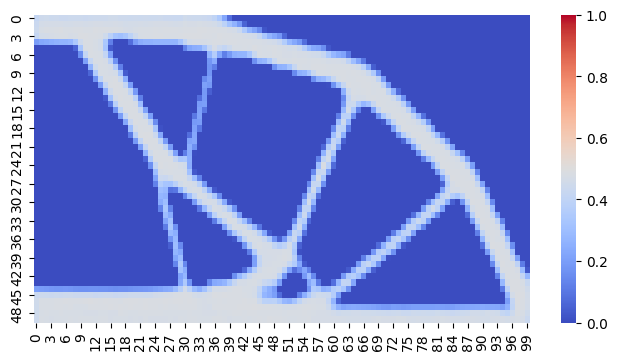

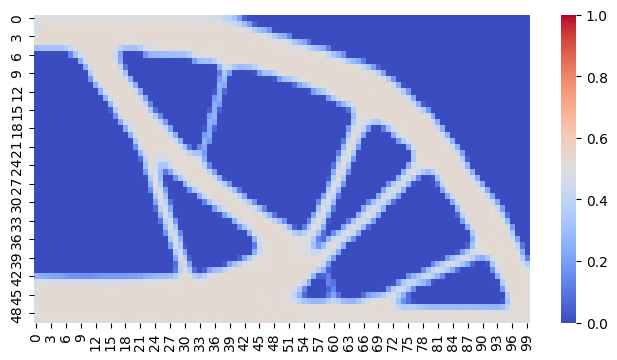

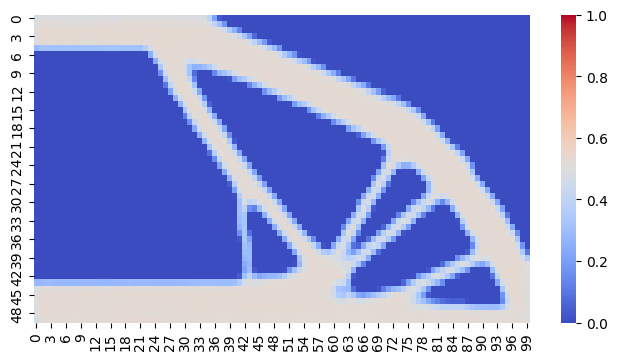

In [6]:
n_samples = 3

conditions = [
    {"volfrac": 0.35, "rmin": 2.0, "forcedist": 0.2, "overhang_constraint": 0.0},
    {"volfrac": 0.45, "rmin": 2.0, "forcedist": 0.2, "overhang_constraint": 0.0},
    {"volfrac": 0.4, "rmin": 2.0, "forcedist": 0.35, "overhang_constraint": 0.0},
]

conditions_tensor = th.tensor([list(c.values()) for c in conditions], device=device)
conditions_tensor = conditions_tensor.unsqueeze(1)  # Add channel dim

design_shape = problem.design_space.shape
# Denoise the designs in batch
gen_designs = th.randn((n_samples, 1, *design_shape), device=device)
for i in reversed(range(run.config["num_timesteps"])):
    t = th.full((n_samples,), i, device=device, dtype=th.long)
    gen_designs = ddm_sampler.sample_timestep(model, gen_designs, t, conditions_tensor)

gen_designs = gen_designs.cpu().numpy()
gen_designs = gen_designs.squeeze()  # Remove the channel dim
np.clip(gen_designs, 0, 1, out=gen_designs) # Sometimes our models generate designs outside the design space... this is a quick fix

# Render the designs
for i in range(n_samples):
    problem.render(gen_designs[i])

## Evaluating the model

### Optimizing generated designs

Let's first optimize the generated designs, to see how far away they are from optimal designs

In [8]:
opt_designs = []
opt_histories = []
for i in range(n_samples):
    opt_design, opt_history = problem.optimize(
        starting_point=gen_designs[i],
        config=conditions[i],
    )
    opt_histories.append(opt_history)
    opt_designs.append(opt_design)

### Eyeball testing the model

Render the optimal designs next to the generated designs to get a visual idea

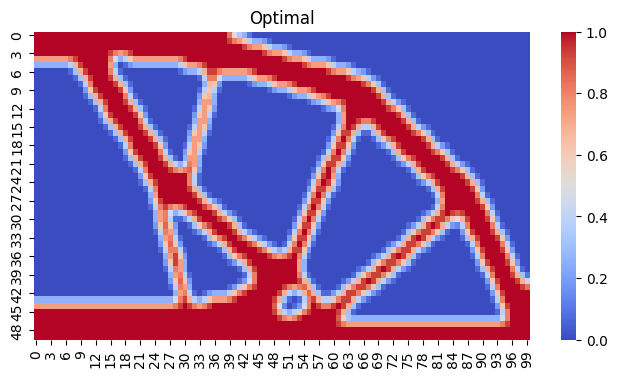

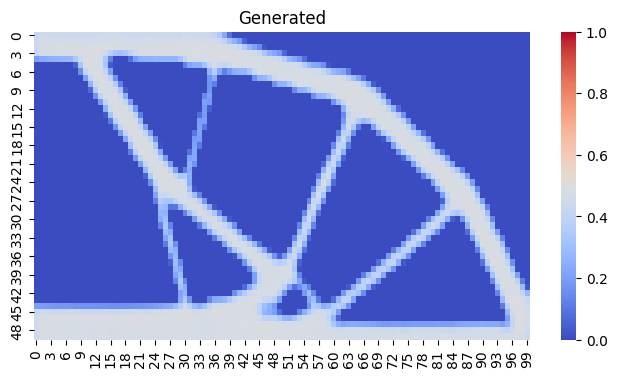

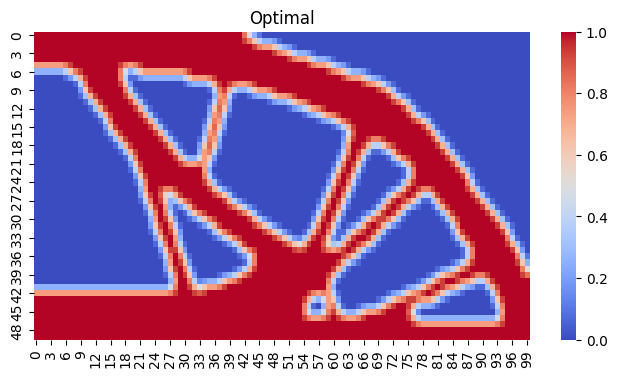

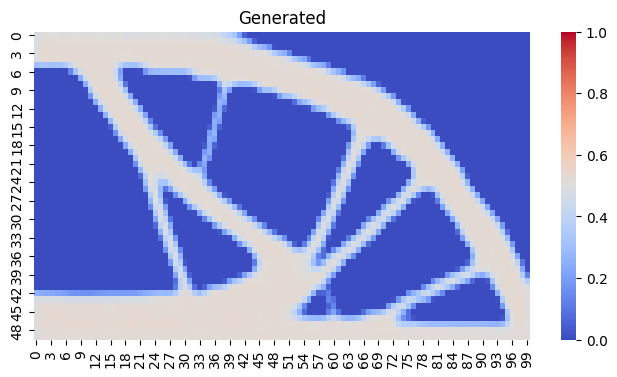

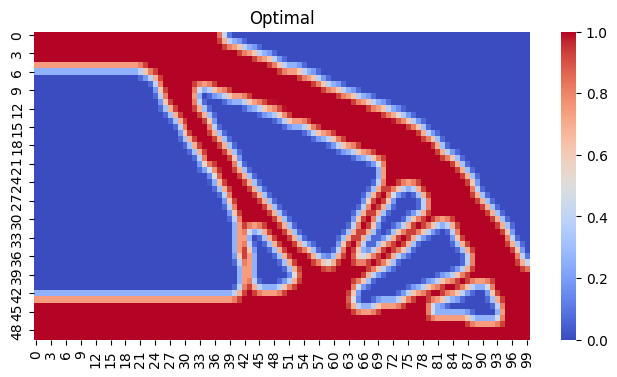

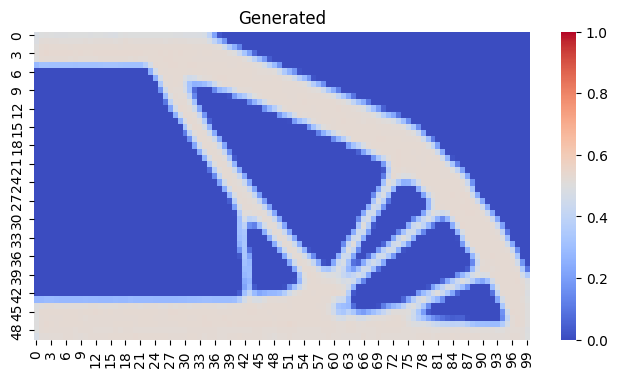

In [9]:
for i in range(n_samples):
    fig_opt, ax_opt = problem.render(opt_designs[i])
    fig_gen, ax_gen = problem.render(gen_designs[i])
    ax_opt.set_title("Optimal")
    ax_gen.set_title("Generated")
    plt.show()

### Qualitative evaluation

Now we can also use metrics to get a quantitative idea of how good the generated designs are. Here we compute optimality gaps between the generated designs and optimized designs in terms of objective values (thermal compliance for heatconduction). We have other metrics available, see the [metrics.py](https://github.com/IDEALLab/EngiOpt/blob/main/engiopt/metrics.py) file for more details.

In [10]:
objective_values_opt = [problem.simulate(opt_designs[i], config=conditions[i]) for i in range(n_samples)]
optimality_gaps = [metrics.optimality_gap(opt_histories[i], baseline=objective_values_opt[i]) for i in range(n_samples)]

iog = [optimality_gaps[i][0][0] for i in range(n_samples)]
cog = [np.sum(optimality_gaps[i]) for i in range(n_samples)]
fog = [optimality_gaps[i][-1][0] for i in range(n_samples)]

print("\033[96m" + f"Initial optimality gaps: {iog}" + "\033[0m")
print("\033[96m" + f"Cumulative optimality gaps: {cog}" + "\033[0m")
print("\033[96m" + f"Final optimality gaps: {fog}" + "\033[0m")

Initial optimality gaps: [1526.228423129462, 667.9952131889916, 567.6915291814789]
Cumulative optimality gaps: [2077.1263896351134, 946.8342947520106, 783.8507213497405]
Final optimality gaps: [-6.5283452912612745, 5.84969148630725, 2.9561198275018796e-05]
